## Import libraries

In [1]:
#Data Manipulation
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#deep learning
# !pip install keras
# !pip install tensorflow
# import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten,Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

#NLP for text pre-processing
import nltk
from nltk.corpus import stopwords
# for spliting data set and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Handling imbalance data
from imblearn.over_sampling import SMOTE
# Plot the Figures Inline
%matplotlib inline

## Exploratory Data Analysis
Before moving ahead, let's look at the distribution of each category.

In [2]:
# Read the Data here
products = pd.read_csv('train_product_data.csv')
#products.head()
products.shape

(14999, 15)

In [3]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  14999 non-null  object 
 1   crawl_timestamp          14999 non-null  object 
 2   product_url              14999 non-null  object 
 3   product_name             14999 non-null  object 
 4   product_category_tree    14999 non-null  object 
 5   pid                      14999 non-null  object 
 6   retail_price             14942 non-null  float64
 7   discounted_price         14942 non-null  float64
 8   image                    14996 non-null  object 
 9   is_FK_Advantage_product  14999 non-null  bool   
 10  description              14998 non-null  object 
 11  product_rating           14999 non-null  object 
 12  overall_rating           14999 non-null  object 
 13  brand                    10289 non-null  object 
 14  product_specifications

In [4]:
products.describe()

,retail_price,discounted_price
count,14942.000000,14942.000000
mean,3128.424040,2087.732298
std,9154.463342,7712.247869
min,35.000000,35.000000
25%,699.000000,349.000000
50%,1000.000000,499.000000
75%,1989.750000,999.000000
max,571230.000000,571230.000000


In [5]:
products.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,Footwear,SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
2,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."


In [6]:
# Split by ',' first, then split by '&', and remove whitespace
products['product_category_tree'] = products['product_category_tree'].str.replace('&', ',')

# Split the product_category_tree column by "," and extract the first level category
products['product_category'] = products['product_category_tree'].apply(lambda x: x.split(',')[0].strip())

# Get the frequency count of each category
category_counts = products['product_category'].value_counts()

# Remove the leading characters from the category names
#category_counts.index = category_counts.index.str[2:]

# Display the top 20 categories
categories = category_counts.head(20)
print(categories)

product_category
Clothing      5316
Jewellery     3218
Footwear      1083
Automotive     937
Mobiles        768
Home Decor     714
Kitchen        610
Computers      531
Watches        526
Tools          379
Toys           271
Pens           264
Baby Care      224
Bags           158
Name: count, dtype: int64


Data Visualisation

<Axes: title={'center': 'Product Category Distribution'}, xlabel='product_category'>

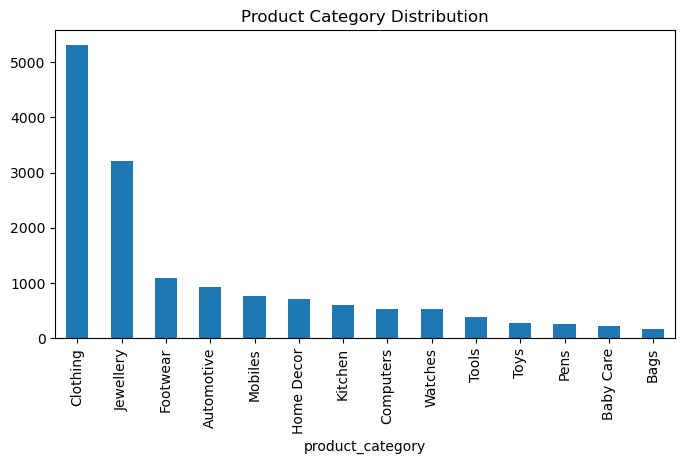

In [7]:
fig, ax = plt.subplots(figsize=[8,4], nrows=1, ncols=1)
categories.plot(ax=ax, kind='bar', title='Product Category Distribution')

## Data Preprocessing
In this program, we are bound to do certain data preprocessing steps, including data cleaning, preparation, transformation, and dimensionality reduction.

First, we investigate the usual data set level cleaning and then later jump into text preprocessing.

Let's see if there are any missing values in the description column.

In [8]:
# Number of missing values in each column
missing = pd.DataFrame (products.isnull().sum()).rename (columns = {0: 'missing' })

# Create a percentage of missing values
missing['percent'] = missing['missing'] / len(products)

# sorting the values in descending order to see highest count on the top
missing.sort_values ('percent', ascending = False)

,missing,percent
brand,4710,0.314021
retail_price,57,0.003800
discounted_price,57,0.003800
product_specifications,6,0.000400
image,3,0.000200
description,1,0.000067
uniq_id,0,0.000000
crawl_timestamp,0,0.000000
product_url,0,0.000000
product_name,0,0.000000


C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


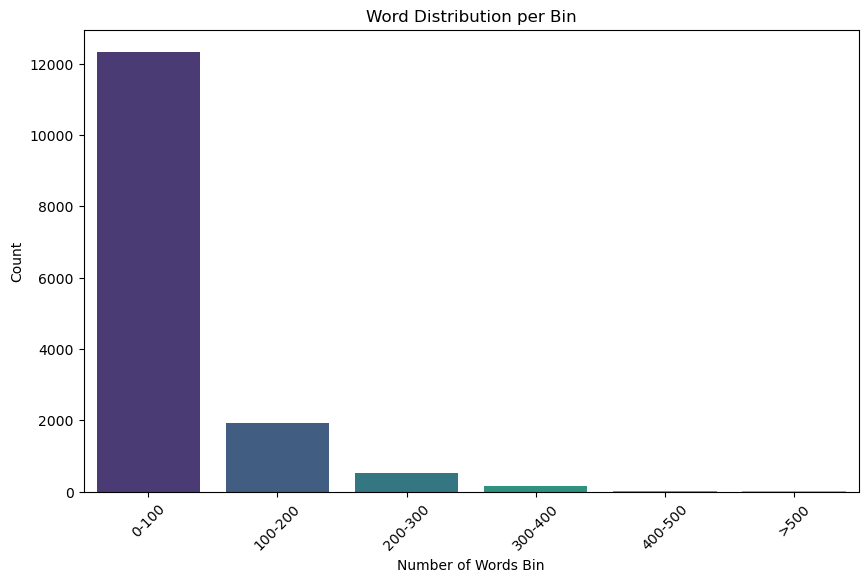

In [9]:
# Removing missing values in 'description'
products = products[products['description'].notna()]

# Adding a new column 'no_of_words'
products.loc[:, 'no_of_words'] = products['description'].str.split().str.len()

# Defining bins
bins = [0, 100, 200, 300, 400, 500, np.inf]
labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '>500']

# Adding a new column 'bins'
products.loc[:, 'bins'] = pd.cut(products['no_of_words'], bins=bins, labels=labels, right=False)

# Grouping and counting the word distribution per bin
words_distribution = products.groupby('bins', observed=True).size().reset_index(name='word_counts')

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='bins', y='word_counts', data=words_distribution, palette='viridis')
plt.title("Word Distribution per Bin")
plt.xlabel('Number of Words Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

## Text Preprocessing
We already observed the value that text preprocessing lends to many text-related tasks. Let's jump into implementation.

The following is data before text preprocessi.



In [10]:
products['description'][8]

"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, White, Black,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach Additional Details Style Code ALTHT_3P_17 In the Box 3 shorts"

In [11]:
products.loc[:, 'description'] = (
    products['description']
    .str.replace(r'[^\w\s]', ' ', regex=True)   # Remove punctuation
    .str.replace(r'\s+', ' ', regex=True)       # Remove extra whitespace
    .str.lower()                                # Convert to lowercase
    .str.replace(r'\d+', 'numbr', regex=True)   # Replace numbers with 'numbr'
)

# Access the preprocessed description at index 8
print(products.loc[8, 'description'])


key features of alisha solid women s cycling shorts cotton lycra black white black specifications of alisha solid women s cycling shorts shorts details number of contents in sales package pack of numbr fabric cotton lycra type cycling shorts general details pattern solid ideal for women s fabric care gentle machine wash in lukewarm water do not bleach additional details style code altht_numbrp_numbr in the box numbr shorts


In [12]:
# Removing Stopwords
from nltk.data import find
try:
    find('corpora/stopwords.zip')
except LookupError:
    nltk.download('stopwords')
stop = set(stopwords.words('english'))

# Create a regex pattern to match any stopword
pattern = r'\b(?:{})\b'.format('|'.join(stop))

# Remove stopwords
products.loc[:, 'description'] = products['description'].str.replace(pattern, '', regex=True)

# Remove extra whitespace
products.loc[:, 'description'] = products['description'].str.replace(r'\s+', ' ', regex=True)

# Remove single characters
products.loc[:, 'description'] = products['description'].str.split().apply(lambda words: ' '.join(word for word in words if len(word) > 1))

# Access the preprocessed description at index 8
print(products.loc[8, 'description'])

key features alisha solid women cycling shorts cotton lycra black white black specifications alisha solid women cycling shorts shorts details number contents sales package pack numbr fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm water bleach additional details style code altht_numbrp_numbr box numbr shorts


In [13]:
#!pip install wordcloud
from wordcloud import WordCloud

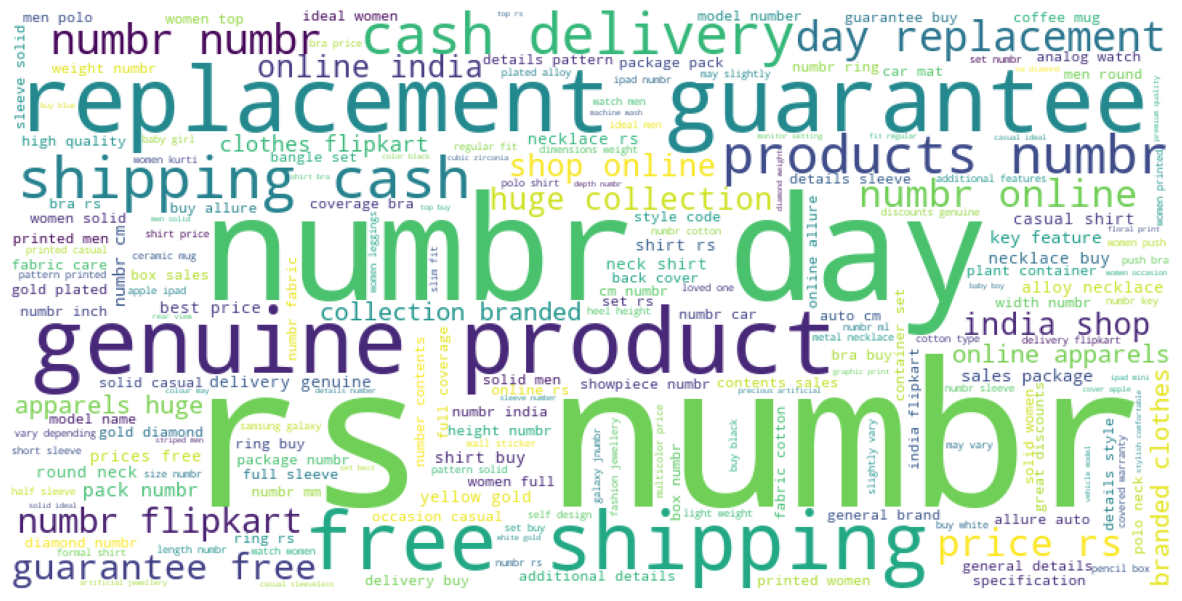

In [14]:
wordcloud = WordCloud(background_color="white", width = 800, height = 400).generate(' '.join(products['description']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [15]:
# Define the specific stop words
specific_stop_words = {"numbr", "rs", "flipkart", "buy", "com", "free", "day", "cash", "replacement", 
                       "guarantee", "key", "feature", "delivery", "products", "product", 
                       "shipping", "online", "india", "shop","code","pack","price"}

# Removing domain-related stop words from the description
products.loc[:, 'description'] = products['description'].apply(
    lambda desc: " ".join(word for word in desc.split() if word not in specific_stop_words))

# Display the cleaned description at index 8
print(products.loc[8, 'description'])

features alisha solid women cycling shorts cotton lycra black white black specifications alisha solid women cycling shorts shorts details number contents sales package fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm water bleach additional details style altht_numbrp_numbr box shorts


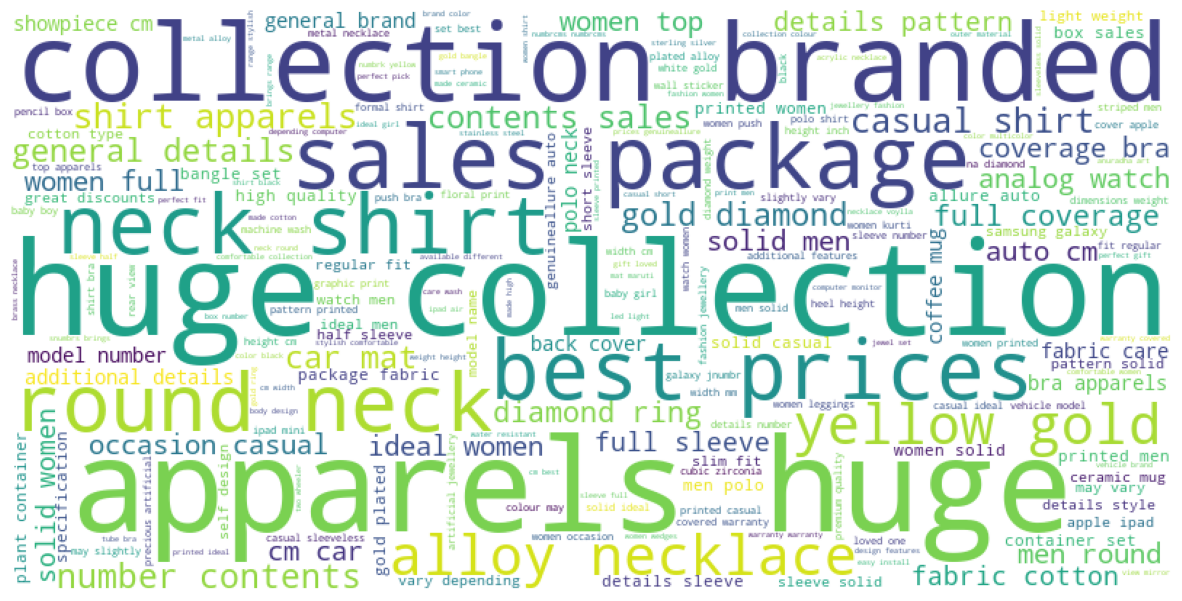

In [16]:
wordcloud  = WordCloud (background_color="white", width = 800, height = 400).generate(''.join(products['description']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Feature Engineering
### To build the text classification model, we need to first convert the text data into features.

We use deep learning algorithms to build the classifier, and feature extraction should be carried out accordingly. We use the Keras tokenizer function to generate features. We are setting max_length to 200, which means we are only considering 200 features for the classifier. This number also decides the accuracy, and the ideal number can be obtained from hyperparameter tuning.

In [17]:
MAX_LENGTH= 200
prod_tok = Tokenizer()
prod_tok.fit_on_texts (products['description'])
clean_description = prod_tok.texts_to_sequences (products['description'])
#padding
X = pad_sequences(clean_description, maxlen = MAX_LENGTH)

In [18]:
# Label encoder for Target variable
from sklearn.preprocessing import LabelEncoder
num_class = len (np.unique (products.product_category_tree.values))
y = products['product_category_tree'].values
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

## Train-Test Split

The data is split into two parts: one for training the model and one for evaluating the model.

The train_test_split library from sklearn.model_selection is imported to split the data frame.

In [19]:
#train test split
from sklearn.model_selection import train_test_split
indepentent_features_build, indepentent_features_valid, depentent_feature_build, depentent_feature_valid = train_test_split(X, y, test_size=0.2, random_state=1) #train 80, test 20
print (indepentent_features_build.shape)
print(indepentent_features_valid.shape)
print(depentent_feature_build.shape)
print(depentent_feature_valid.shape)

(11998, 200)
(3000, 200)
(11998,)
(3000,)


## Model summary

In [20]:
model_inp = Input(shape=(MAX_LENGTH,))
vocab_size = len(prod_tok.word_index) + 1  # Adding 1 for the unknown token (index 0)
object_layer = Embedding(vocab_size, 100)(model_inp)
a = Flatten()(object_layer)
a = Dense(30, activation='relu')(a)

# Default activation function is linear, we can make use of relu.
model_pred = Dense(num_class, activation='softmax')(a)
output = Model(inputs=[model_inp], outputs=model_pred)
output.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
output.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 100)            │       1,569,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │         600,030 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             434 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,170,264 (8.28 MB)

 Trainable params: 2,170,264 (8.28 MB)

 Non-trainable params: 0 (0.00 B)

## Model Building
The following list of classifiers is used for creating various classification models, which can be further used for prediction.

Simple baseline artificial neural networks (ANNs)

Recurrent neural networks (RNN-LSTM)

Convolutional neural networks

In [31]:
filepath="output_ANN.keras"
X = ModelCheckpoint (filepath, monitor= 'val_acc', verbose=1, save_best_only=True, mode='max')

#fit the model
out = output.fit([indepentent_features_build], batch_size=64, y=to_categorical (depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])

#predict
output_pred = output.predict(indepentent_features_valid)
output_pred = np.argmax(output_pred, axis=1)
accuracy_score = (depentent_feature_valid, output_pred)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - acc: 0.5548 - loss: 1.5100
Epoch 1: val_acc improved from -inf to 0.89267, saving model to output_ANN.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - acc: 0.5559 - loss: 1.5063 - val_acc: 0.8927 - val_loss: 0.3979
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - acc: 0.9274 - loss: 0.2779
Epoch 2: val_acc improved from 0.89267 to 0.94133, saving model to output_ANN.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - acc: 0.9275 - loss: 0.2775 - val_acc: 0.9413 - val_loss: 0.1913
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - acc: 0.9655 - loss: 0.1116
Epoch 3: val_acc improved from 0.94133 to 0.96167, saving model to output_ANN.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - acc: 0.9655 - loss: 0.1115 - val_acc: 0.9617 - val_loss: 0.1540
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - acc: 0.9822 - loss: 0.0676
Epoch 4: val_acc did not improve from 0.96167
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step

In [35]:
# Calculate accuracy
# Predict
output_pred = output.predict(independent_features_valid)
output_pred = np.argmax(output_pred, axis=1)
accuracy = accuracy_score(dependent_feature_valid, output_pred)
print(f"Validation Accuracy: {accuracy}")

# Prepare data for plotting
dfaccuracy = pd.DataFrame({
    'Number of Epoch': range(1, len(out.history['acc']) + 1),
    'Training Accuracy': out.history['acc'],
    'Validation Accuracy': out.history['val_acc']
})

# Plotting accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='Number of Epoch', y='Training Accuracy', data=dfaccuracy, label='Training Accuracy')
sns.lineplot(x='Number of Epoch', y='Validation Accuracy', data=dfaccuracy, label='Validation Accuracy', color='red')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

NameError: name 'independent_features_valid' is not defined

## Long Short-Term Memory: Recurrent Neural Networks
We tried out normal neural networks which don't capture the sequence of the data. Let's try a long short-term memory network where the sequence is also captured while training the model. This is best suited for text since text data is sequential.

In [22]:
model_inp  = Input (shape=(MAX_LENGTH, ))

#define embedding layer
object_layer = Embedding(vocab_size, 100) (model_inp)

#add LSTM layer
a = LSTM(60) (object_layer)

#add dense layer
a = Dense(30)(a) #default activation function is linear, we can make use of relu.

#final
model_pred = Dense (num_class, activation='softmax')(a)
output = Model(inputs = [model_inp], outputs=model_pred)

#compile
output.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
output.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 200, 100)            │       1,569,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60)                  │          38,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 14)                  │             434 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,610,704 (6.14 MB)

 Trainable params: 1,610,704 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

filepath="output_LSTM.keras"

#model checkpoint
X = ModelCheckpoint (filepath, monitor = 'val_acc', verbose=1, save_best_only=True, mode='max')

#fitting
out = output.fit([indepentent_features_build], batch_size=64, y=to_categorical(depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])
output.load_weights ('output_LSTM.keras')

#predicting on validation data
output_pred = output.predict(indepentent_features_valid)
output_pred = np.argmax (output_pred, axis=1)

#score
accuracy_score (depentent_feature_valid, output_pred)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - acc: 0.5467 - loss: 1.6001
Epoch 1: val_acc improved from -inf to 0.84400, saving model to output_LSTM.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - acc: 0.5476 - loss: 1.5970 - val_acc: 0.8440 - val_loss: 0.6348
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - acc: 0.8868 - loss: 0.4401
Epoch 2: val_acc improved from 0.84400 to 0.89467, saving model to output_LSTM.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - acc: 0.8869 - loss: 0.4395 - val_acc: 0.8947 - val_loss: 0.3712
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - acc: 0.9415 - loss: 0.1972
Epoch 3: val_acc improved from 0.89467 to 0.93200, saving model to output_LSTM.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 235ms/step - acc: 0.9415 - loss: 0.1970 - val_acc: 0.9320 - val_loss: 0.2179
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - acc: 0.9717 - loss: 0.1058
Epoch 4: val_acc improved from 0.93200 to 0.94433, saving model to output_LSTM.keras
1

0.9683333333333334

C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

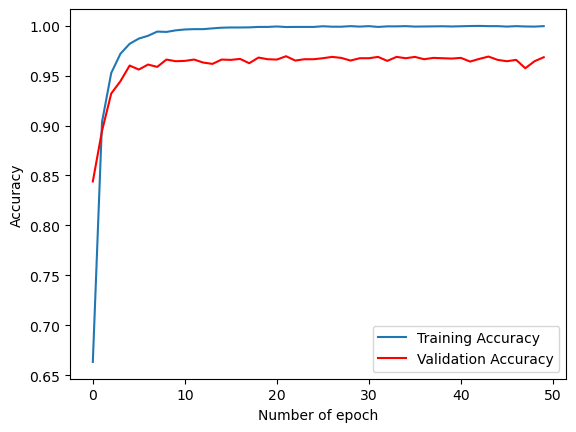

In [24]:
# Create DataFrame with training and validation accuracy
dfaccuracy = pd.DataFrame({
    'Number of epoch': out.epoch,
    'Model hist': out.history['acc'],
    'Model Perd': out.history['val_acc']
})

# Replace 'inf' values with 'NaN'
dfaccuracy.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Line plot for train accuracy
g = sns.lineplot(x="Number of epoch", y="Model hist", data=dfaccuracy, label='Training Accuracy')

# Line plot for test accuracy
g = sns.lineplot(x="Number of epoch", y="Model Perd", data=dfaccuracy, color='red', label='Validation Accuracy')

# Set y-axis label
g.set_ylabel('Accuracy')

# Add legend
plt.legend()

# Show the plot
plt.show()



In [28]:
model_inp = Input (shape=(MAX_LENGTH, ))

# define the layer
object_layer = Embedding (vocab_size, 100, input_length=MAX_LENGTH) (model_inp)

#conv layer
a = Conv1D(60, 10) (object_layer) #default activation function is linear, we can make use of relu.

#add pooling layer
a = MaxPooling1D (pool_size=2) (a)

#add LSTM
a = LSTM(60)(a)
a = Dense (30)(a)

#final layer
model_pred = Dense (num_class, activation='softmax')(a)
output = Model (inputs = [model_inp], outputs=model_pred)

#compile
output.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['acc'])
output.summary()

C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 200, 100)            │       1,569,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 191, 60)             │          60,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 95, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60)                  │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 14)                  │             434 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,661,164 (6.34 MB)

 Trainable params: 1,661,164 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

Convolutional Neural Networks
These types of networks are mainly used for image processing. But recent trends show that CNN is performing well on text data if the right parameters are used. Let's see how well it performs in this case.

In [26]:
filepath="output_CNN.keras"

X = ModelCheckpoint (filepath, monitor= 'val_acc', verbose=1, save_best_only=True, mode='max')

out = output.fit([indepentent_features_build], batch_size=64, y=to_categorical (depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])

output.load_weights ('output_CNN.keras')

predicted = output.predict(indepentent_features_valid)

predicted = np.argmax (predicted, axis=1)
accuracy_score (depentent_feature_valid, predicted)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - acc: 0.5769 - loss: 1.4569
Epoch 1: val_acc improved from -inf to 0.89733, saving model to output_CNN.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 170ms/step - acc: 0.5780 - loss: 1.4533 - val_acc: 0.8973 - val_loss: 0.3925
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - acc: 0.9238 - loss: 0.2828
Epoch 2: val_acc improved from 0.89733 to 0.94833, saving model to output_CNN.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - acc: 0.9238 - loss: 0.2825 - val_acc: 0.9483 - val_loss: 0.1932
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - acc: 0.9665 - loss: 0.1193
Epoch 3: val_acc improved from 0.94833 to 0.95633, saving model to output_CNN.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - acc: 0.9665 - loss: 0.1193 - val_acc: 0.9563 - val_loss: 0.1581
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - acc: 0.9826 - loss: 0.0675
Epoch 4: val_acc improved from 0.95633 to 0.96433, saving model to output_CNN.keras
141/1

0.9656666666666667

C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mohan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

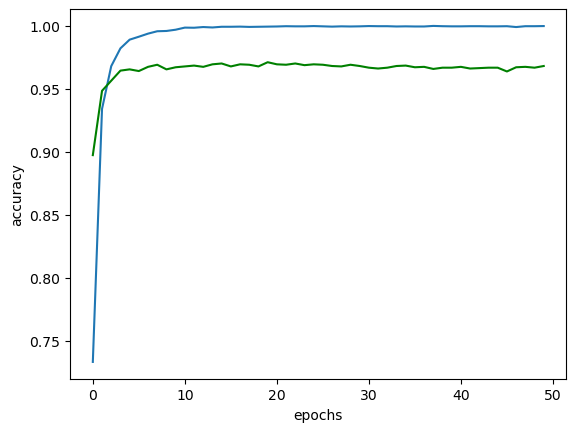

In [27]:
dfaccuracy = pd.DataFrame({'epochs': out. epoch, 'accuracy': out. history['acc'], 'validation_accuracy': out. history['val_acc']})
# Line for train accuracy
g = sns.lineplot(x="epochs", y="accuracy", data=dfaccuracy)

# Line for test accuracy
g = sns.lineplot(x="epochs", y="validation_accuracy", data=dfaccuracy, color='green')